In [23]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
sys.path.append('./calina')

from calibration_dataset import Tell1Dataset, DatasetTree
import calibration_dataset as DS

dataset_path = '/home/mwm/repositories/LHCb/ml_analysis_recreation/data/calibrations'
class MyDS(Tell1Dataset):
    filename_format = '%Y-%m-%d'
    filename_regex_format = r'\d{4}-\d{2}-\d{2}.csv'
data_list = MyDS.get_filepaths_from_dir(dataset_path)
dataset = MyDS(data_list, read=True)
from pathlib import Path
plot_output = Path('/home/mwm/repositories/LHCb/ml_analysis_recreation/paper/pics/')


from dataset import Tell1Dataset, DatasetTree
import dataset as DS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
import matplotlib
matplotlib.rcParams['image.cmap'] = 'rainbow'
output_notebook()

100%|██████████| 30/30 [00:04<00:00,  6.52it/s]


ModuleNotFoundError: No module named 'dataset'

Read dataset:

In [ ]:
def sensor_histogram(data):
    x_data_list = []
    y_data_list = []
    for i,column in enumerate(data):
        y_data = list(data[column].values)
        y_data_list += y_data
        x_data_list += [i]*len(y_data)
    return x_data_list, y_data_list

# Tell Parameters

In [ ]:
#some plot of raw signal

Imagine detecor as a large osciloscope. This is the image of it.

We want to know ehre the hits are so we need to detect 2 things:
- Standard deviation of noise (pedestals)
- The mean value (threshold)

To record a hit, a clusterign algorithms uses those two values. (or actually three)

# Pedestals

Pedestals are the mean values registered in channel over some time. These values are used to level the output from the detector, so that it would be as close to zero as possible.

The plot below represents the pedestal value in **all calibrations** for **all sensors**, both R-type and Phi-type.

In [25]:
data = dataset.dfp.df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('All module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0, 0.5, 'ADC')

## Important!!
 - We can see a spike around 1700 channel, in both R an phi type of sensor. Reason for this spike is unknown.

The plot has been repeated for R-type sensors and Phi-type sensors below.

### R-type

Text(0, 0.5, 'ADC')

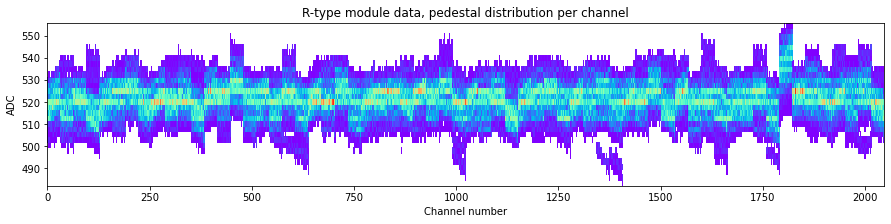

In [26]:
data = dataset.dfp['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('R-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

### Phi - type

Text(0, 0.5, 'ADC')

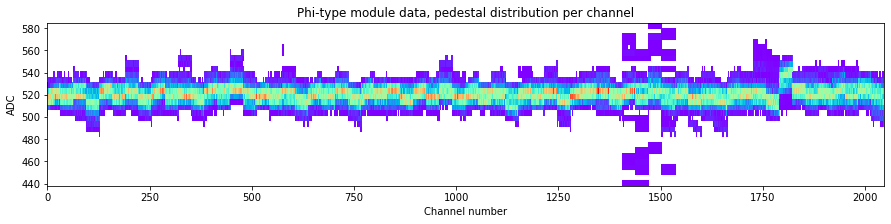

In [27]:
data = dataset.dfp['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('Phi-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

## Pedestal trending

Below you can find small snippet, that allows you to look at the trending of the indivdual channels in selected sensor.

In [28]:
from sklearn import linear_model
plotset = dataset.dfp['#0'].df
y = plotset['channel0']
x = plotset['datetime']
model = linear_model.LinearRegression()
modelx = x.values[:,np.newaxis]
modely = y.values[:,np.newaxis]
model.fit(modelx.astype(np.float64), modely)
Y_pred = model.predict(modelx.astype(np.float64))
p = figure(title="Individual channel pedestal values of sensor in time, with linear trend", plot_height=300, plot_width=600)
r = p.circle(x, y, color="#2222aa", line_width=3)
r2 = p.line(x, Y_pred[:,0], color="green", line_width=3)
from bokeh.models import DatetimeTickFormatter
p.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )
p.xaxis.major_label_orientation = 3.1415/4
def update2(sensor, channel):
    model = linear_model.LinearRegression()
    modelx = x.values[:,np.newaxis]
    plotset = dataset.dfp[sensor].df
    y = plotset['channel'+str(channel)]
    modely = y.values[:,np.newaxis]
    model.fit(modelx.astype(np.float64), modely)
    Y_pred = model.predict(modelx.astype(np.float64))
    r.data_source.data['y'] = y
    r2.data_source.data['y'] = Y_pred[:,0]
    push_notebook()
show(p, notebook_handle=True)

In [29]:
interact(update2, sensor=DS.sensor_numbers, channel=(0,2047))

interactive(children=(Dropdown(description='sensor', options=('#0', '#1', '#2', '#3', '#4', '#5', '#6', '#7', …

<function __main__.update2(sensor, channel)>

### Trending as linear regression coefficient

Of course looking at each channel indivudally is not very handy to asses the overall trends. Below we will calculate the coefficients for each individual channel, in each sensor, thus reducing the time dimension to one varaible.

Below are the functions that calculate coefficients for each channel. **Note: We convert time dimension into days**

In [30]:
from sklearn.preprocessing import normalize

def get_coef(x,y):
    model = linear_model.LinearRegression()
    modely = y.values[:,np.newaxis]
    modelx = x[:,np.newaxis]
    model.fit(modelx, modely)
    return model.coef_[0]

def get_df_coef(df):
    time = df['datetime'].values
    time = (time-time.min())/np.timedelta64(1,'D')
    ret = []
    for column in df.iloc[:,9:]:
        y=df[column]
        coef = get_coef(time, y)
        ret.append(coef)
    return np.array(ret).T

We group dataset entries by sensor, and calculate, and calculate coefficient for each channel. That reduces each group to 1d vector of coeficcients.

In [31]:
group = dataset.dfp.df.groupby(['sensor_number'])
results = {}
for groupname, data in group:
    results[groupname] = get_df_coef(data)[0]

Because we only used channel values, we discarded other informations (sensor type, etc.) during calculation, we merge it with calculated coeficient dataframe.

In [32]:
coefs = pd.DataFrame.from_dict(results,orient='index')
coefs.columns = [ "channel"+str(i) for i in list(coefs.columns)]
coefs = coefs.reset_index()
coefs = coefs.rename(columns={'index':'sensor_number'})

data = dataset.dfp.df
data = data.drop(data.iloc[:,9:].columns , axis=1)
data = data.drop(['datetime'], axis=1)
data = data.reset_index(drop=True)
dara = data.drop_duplicates()
total_coefs = pd.merge(dara, coefs, on='sensor_number')

We create the histogram of all the pedestal coefficients below:

Text(0, 0.5, 'ADC')

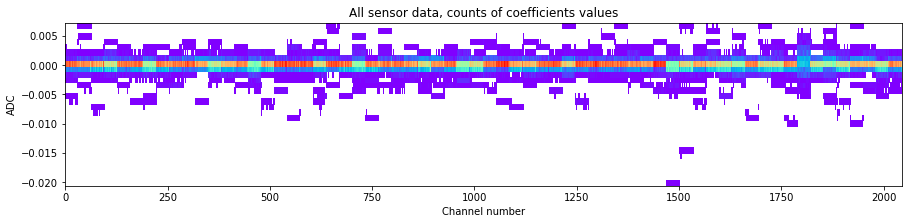

In [33]:
data = total_coefs.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('All sensor data, counts of coefficients values')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

We can see that it oscillates around zero, which means that there is almost no general trend. The automatic scaling of this iamge suggest that there is small number of channels that register greater decrease in pedestal values.

## Important!!:
    - There is no general trend.
    - Some channels registered greater trend.

Lets take a lok at overall histogram plot of coefficients:

Text(0.5, 0, 'Coefficient value')

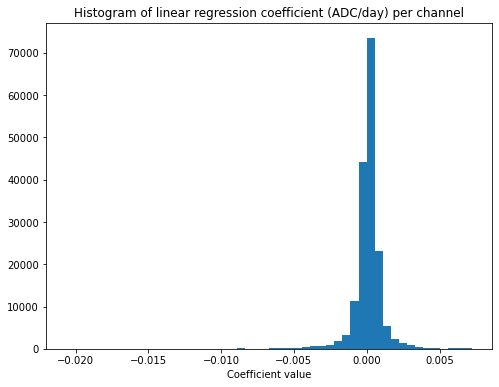

In [34]:
fig, axe = plt.subplots(1,1, figsize=(8,6))
_ = plt.hist(total_coefs.iloc[:,9:].values.ravel(),bins=50)
axe.set_title('Histogram of linear regression coefficient (ADC/day) per channel')
axe.set_xlabel('Coefficient value')

In [36]:
total_coefs.iloc[:,9:].values.ravel().mean()

9.623530160638318e-05

In [ ]:
o

lets see log plot

Text(0.5,0,'Coefficient value')

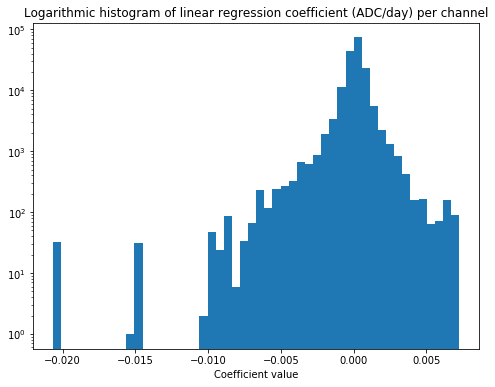

In [15]:
fig, axe = plt.subplots(1,1, figsize=(8,6))
_ = plt.hist(total_coefs.iloc[:,9:].values.ravel(),bins=50,log=True)
axe.set_title('Logarithmic histogram of linear regression coefficient (ADC/day) per channel')
axe.set_xlabel('Coefficient value')

Lets calculate mean coefficient.

In [16]:
total_coefs.iloc[:,9:].mean().mean()

9.623530160638315e-05

its 9.62e-05 a, yearly its

In [17]:
9.62e-05*360

0.034631999999999996

In [18]:
total_coefs.iloc[:,9:].values.ravel().std()

0.0010646114908681114

In [19]:
0.0010646114908681114 * 360

0.38326013671252007

0.03 ADC per year - it is not a signifficat value

## Important!!:
 - we can definately see some otuliers with coefficients < -0.012

Lets look into that, lets find responsible modules, but lets move treshold a bit to -0.008 to see more examples

In [20]:
outlier = total_coefs.iloc[:,9:]<=-0.008

In [21]:
outlier.columns[outlier.sum() !=0]

Index(['channel480', 'channel544', 'channel545', 'channel546', 'channel547',
       'channel548', 'channel549', 'channel550', 'channel551', 'channel552',
       ...
       'channel1942', 'channel1943', 'channel1944', 'channel1945',
       'channel1946', 'channel1947', 'channel1948', 'channel1949',
       'channel1950', 'channel1951'],
      dtype='object', length=227)

In [22]:
total_coefs[outlier.sum(axis=1)!=0]['sensor_number']

35    #35
61    #83
63    #85
Name: sensor_number, dtype: object

We can see 3 modules listed, lets see at the plot of coefficients per channel, for two of those: 

#### Module #85

We can see definately that there is something wrong with this module looking at the all pedestal values histogram:

Text(0,0.5,'ADC')

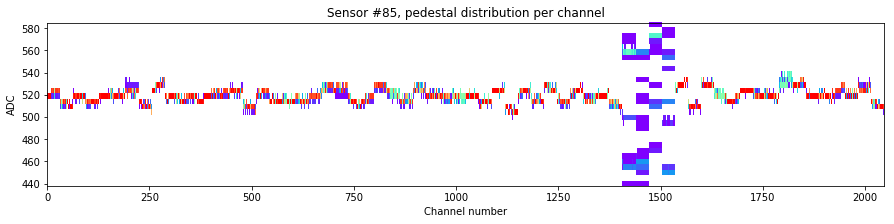

In [23]:
data = dataset.dfp['#85'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('Sensor #85, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

We can take a look back to interactive trending to see that the values of pedestals are the same for the same channel. And **do not change** in 3 groups of channels: 1408-1439, 1440-1471, 1472-1535

#### Module #35 - for comparison

Text(0,0.5,'ADC')

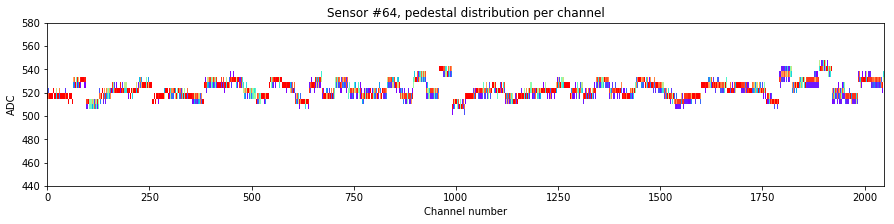

In [24]:
data = dataset.dfp['#64'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],  range=[[0,2048],[440,580]],cmin=1)
axe.set_title('Sensor #64, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In [25]:
data = dataset.dfp['#64'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('Sensor #64, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0,0.5,'ADC')

# Summary:

 - There is probable design flaw that creates the spike in channels around 1700
 - Pedestal values stay roughly the same in time.
 - There is a flaw in the sensor #85, in channels around 1500